In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
import pycaret.regression as pyr


In [2]:
pubg_file = '../DATA/train_V2.csv'
# pubg_test_file = '../DATA/test_V2.csv'
# pubg_test_target_file = '../DATA/sample_submission_V2.csv'


In [3]:
pubgDF = pd.read_csv(pubg_file)
# pubg_test_featureDF = pd.read_csv(pubg_test_file)
# pubg_test_targetDF = pd.read_csv(pubg_test_target_file)
# pubg_testDF = pd.concat([pubg_test_featureDF, pubg_test_targetDF], axis=1)


In [4]:
pubgDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [5]:
pubgDF_drop = pubgDF.drop(['Id', 'groupId', 'matchId'], axis=1)


In [6]:
pubgDF_drop['matchType'].unique()


array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [7]:
pubgDF_drop.columns


Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [8]:
len(pubgDF_drop.columns)


26

In [9]:
pubgDF_duo = pubgDF_drop[pubgDF_drop['matchType'].isin(['duo'])].reset_index(drop=True)
pubgDF_duo = pubgDF_duo.drop(['matchType'], axis=1)


In [10]:
pubgDF_duo_fpp = pubgDF_drop[pubgDF_drop['matchType'].isin(['duo-fpp'])].reset_index(drop=True)
pubgDF_duo_fpp = pubgDF_duo_fpp.drop(['matchType'], axis=1)


In [34]:
def visualize(col_name: str, df: pd.DataFrame, bin: int):
    title_name = col_name.capitalize()
    # f, ax = plt.subplots()
    plt.hist(df[col_name], bins=bin)
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    plt.yscale('log')
    # ax.set_yscale('log')
    # df.hist(column=col_name,ax=ax,bins=bin)
    plt.title('Histogram of ' + title_name)


In [39]:
def visualize_all(df: pd.DataFrame, bin: int):
    plt.figure(figsize=(15, 15))
    for idx, col in enumerate(df.columns, 1):
        plt.subplot(5, 5, idx)
        visualize(col, df, bin)
    plt.tight_layout()
    plt.show()


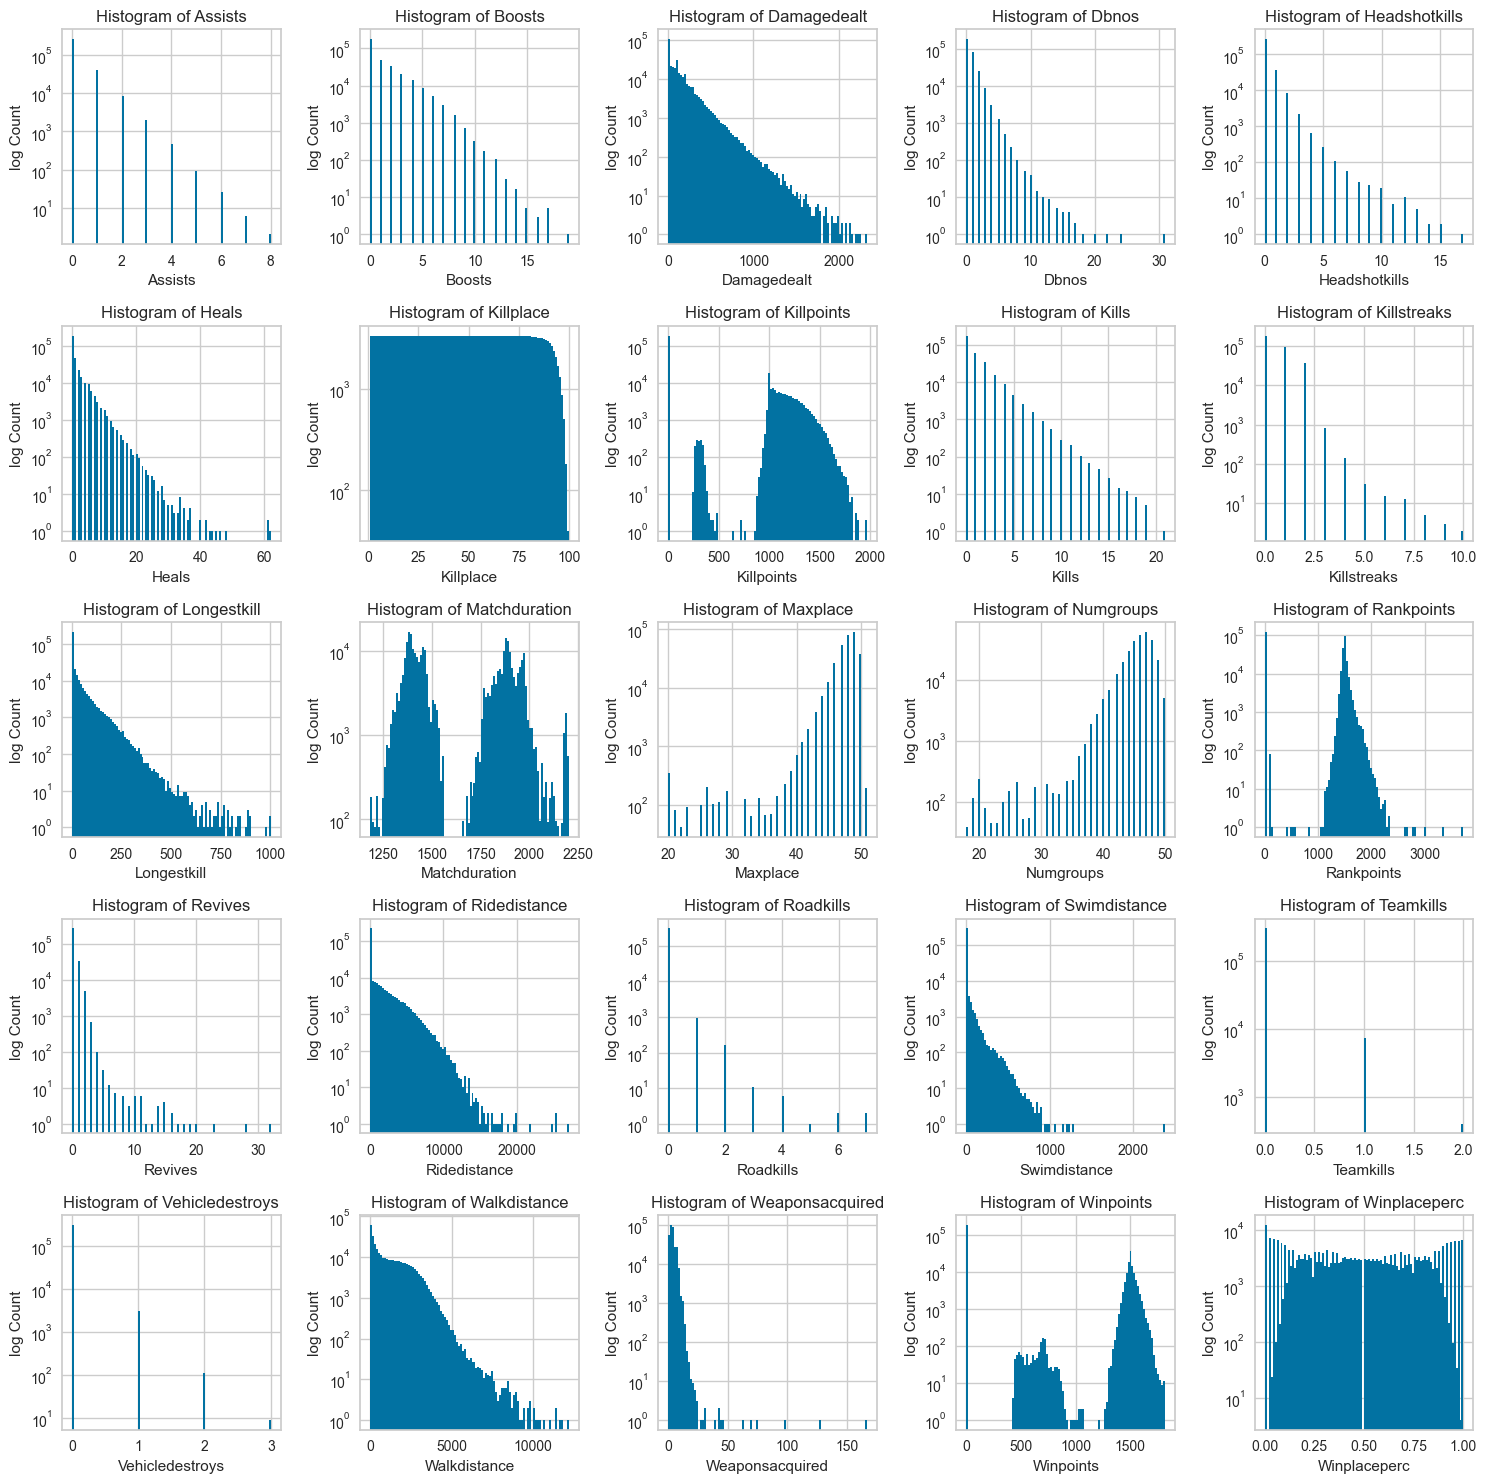

In [40]:
visualize_all(pubgDF_duo, 100)


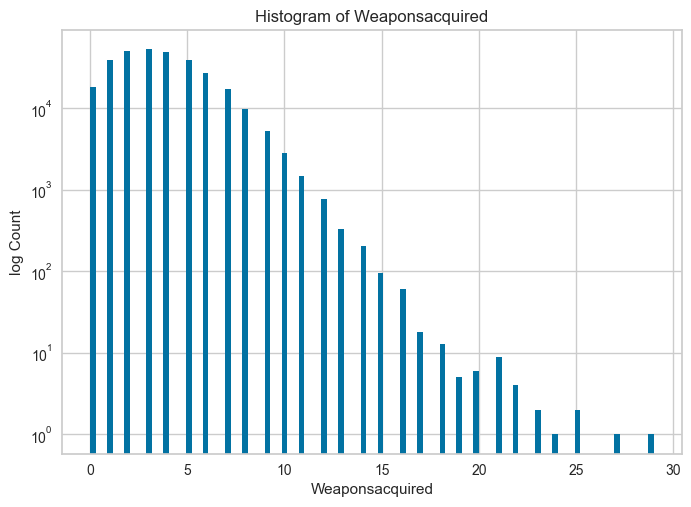

In [81]:
visualize('weaponsAcquired', pubgDF_duo[pubgDF_duo['weaponsAcquired']<30], 100)


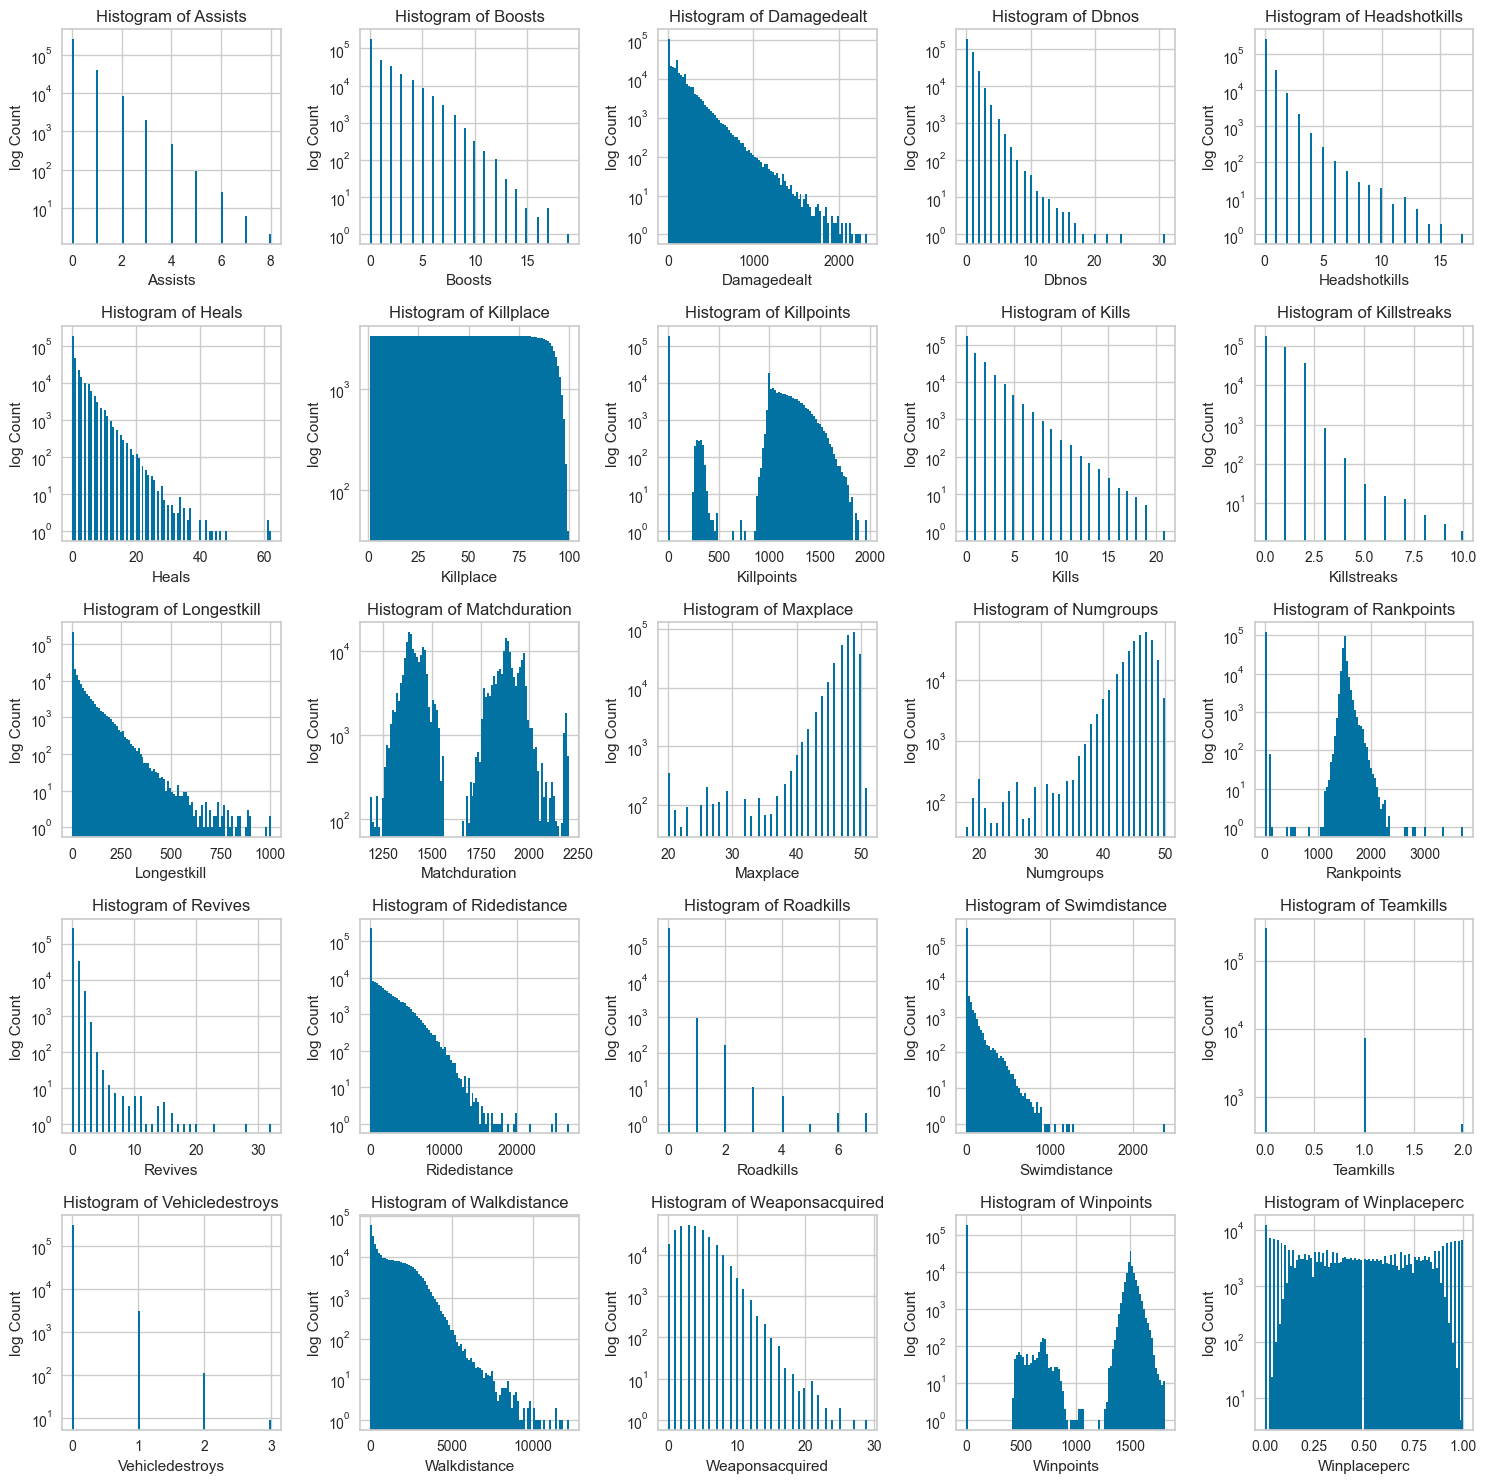

In [82]:
visualize_all(pubgDF_duo[pubgDF_duo['weaponsAcquired']<30], 100)


In [84]:
pubgDF_duo[['rankPoints', 'winPoints']]


,rankPoints,winPoints
0,1491,0
1,-1,1603
2,1534,0
3,1505,0
4,1495,0
...,...,...
313586,1479,0
313587,1374,0
313588,1521,0
313589,-1,1500


In [88]:
pubgDF_duo[['rankPoints', 'winPoints']][(pubgDF_duo['rankPoints'] != -1) & (pubgDF_duo['rankPoints'] != 0) & (pubgDF_duo['winPoints'] != 0)]


,rankPoints,winPoints


In [90]:
pubgDF_duo_points = pubgDF_duo['rankPoints'].replace(-1, 0) + pubgDF_duo['winPoints']


In [91]:
pubgDF_duo_points


0         1491
1         1603
2         1534
3         1505
4         1495
          ... 
313586    1479
313587    1374
313588    1521
313589    1500
313590    1470
Length: 313591, dtype: int64

In [92]:
pubgDF_duo_sample = pubgDF_duo[pubgDF_duo['weaponsAcquired']<30].sample(n=12500)


In [93]:
featureDF = pubgDF_duo_sample.drop(['winPlacePerc'], axis=1)
targetSR = pubgDF_duo_sample['winPlacePerc']


In [94]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(10000, 24) (10000,) (2500, 24) (2500,)


In [95]:
auto_ml = pyr.setup(pubgDF_duo_sample, target='winPlacePerc', train_size=0.8, normalize=True, normalize_method='minmax')


,Description,Value
0,Session id,1517
1,Target,winPlacePerc
2,Target type,Regression
3,Original data shape,"(12500, 25)"
4,Transformed data shape,"(12500, 25)"
5,Transformed train set shape,"(10000, 25)"
6,Transformed test set shape,"(2500, 25)"
7,Numeric features,24
8,Preprocess,True
9,Imputation type,simple


In [96]:
best_models = pyr.compare_models(sort='MAE', fold=5, n_select=10)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0541,0.0057,0.0755,0.9374,0.0496,0.1896,1.6120
lightgbm,Light Gradient Boosting Machine,0.0561,0.0061,0.0783,0.9326,0.0514,0.1915,0.1260
et,Extra Trees Regressor,0.0579,0.0067,0.0816,0.9268,0.0534,0.2012,0.7460
xgboost,Extreme Gradient Boosting,0.0581,0.0066,0.0810,0.9279,0.0532,0.2009,0.1040
rf,Random Forest Regressor,0.0604,0.0074,0.0860,0.9188,0.0561,0.2057,1.2300
gbr,Gradient Boosting Regressor,0.0611,0.0074,0.0859,0.9190,0.0561,0.2177,0.3940
knn,K Neighbors Regressor,0.0747,0.0109,0.1042,0.8807,0.0680,0.2576,0.0500
huber,Huber Regressor,0.0812,0.0129,0.1137,0.8579,0.0743,0.3375,0.0600
lar,Least Angle Regression,0.0823,0.0129,0.1133,0.8589,0.0748,0.3552,0.0120
lr,Linear Regression,0.0823,0.0129,0.1133,0.8589,0.0748,0.3552,0.7360


In [101]:
pyr.evaluate_model(best_models[0])


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…